In [1]:
# all of the imports
import pandas as pd
import numpy as np
import pickle 
import patsy
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.pipeline import make_pipeline
from sklearn.cross_validation import train_test_split
% matplotlib inline
from sklearn import preprocessing as pp
import warnings
warnings.filterwarnings('ignore')

C:\Users\Administrator\Anaconda2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.naive_bayes import MultinomialNB

from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.preprocessing import Normalizer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, classification_report

from sklearn.metrics import make_scorer
from sklearn.metrics import recall_score

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_curve, auc

In [3]:
import nltk
import itertools
from nltk.probability import FreqDist

stopset = set(nltk.corpus.stopwords.words('english'))

In [4]:
def rotate(ax, degree):
    for tick in ax.get_xticklabels():
        tick.set_rotation(degree)

In [5]:
questions = pd.read_csv('./Questions.csv',encoding='latin1')

In [6]:
questions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147075 entries, 0 to 147074
Data columns (total 6 columns):
Id              147075 non-null int64
OwnerUserId     146129 non-null float64
CreationDate    147075 non-null object
Score           147075 non-null int64
Title           147075 non-null object
Body            147075 non-null object
dtypes: float64(1), int64(2), object(3)
memory usage: 6.7+ MB


** Conclusion：OwnerUserId存在缺失值**

In [8]:
questions.head()

,Id,OwnerUserId,CreationDate,Score,Title,Body
0,77434,14008.0,2008-09-16T21:40:29Z,134,How to access the last value in a vector?,<p>Suppose I have a vector that is nested in a...
1,79709,NaN,2008-09-17T03:39:16Z,1,Worse sin: side effects or passing massive obj...,<p>I have a function inside a loop inside a fu...
2,95007,15842.0,2008-09-18T17:59:19Z,48,Explain the quantile() function in R,<p>I've been mystified by the R quantile funct...
3,103312,NaN,2008-09-19T16:09:26Z,4,How to test for the EOF flag in R?,<p>How can I test for the <code>EOF</code> fla...
4,255697,1941213.0,2008-11-01T15:48:30Z,3,Is there an R package for learning a Dirichlet...,<p>I'm looking for a an <code>R</code> package...


In [9]:
# extract all the code part 
a = questions['Body'].str.extractall(r'(<code>[^<]+</code>)')

In [13]:
type(a)
a.head(10)

0
  match                                                   
0 0                                  <code>length()</code>
  1                                        <code>$#</code>
  2                       <code>dat$vec1$vec2[$#]\n</code>
  3      <code>dat$vec1$vec2[length(dat$vec1$vec2)]\n</...
1 0      <code>for (dataset in list_of_datasets) {\n  f...
3 0                                       <code>EOF</code>
  1      <code>f &lt;- file(fname, "rb")\nwhile (???) {...
4 0                                         <code>R</code>
  1                                         <code>R</code>
6 0                                        <code>st</code>

In [10]:
# unstack and convert into a single column for cleaning
test = a.unstack('match')

test.columns = test.columns.droplevel()
# put all columns together
code = pd.DataFrame(test.apply(lambda x: x.str.cat(), axis=1,reduce=True))
# rename 
code.columns = ['CodeBody']
# remove the html tags finally
code['CodeBody'] = code['CodeBody'].str.replace(r'<[^>]+>|\n|\r',' ')

In [14]:
# remove the code part from questions
body = questions['Body'].str.replace(r'<code>[^<]+</code>',' ')
# build up the question part from questions
questions['QuestionBody'] = body.str.replace(r"<[^>]+>|\n|\r", " ")

In [15]:
# Join the codebody by index
questions = questions.join(code)
# final cleaned dataset
questions_final = questions.drop('Body',axis=1)

In [16]:
# assume all answers without userID are from the same guy ID 0
questions_final['OwnerUserId'].fillna(0,inplace=True)
questions_final.OwnerUserId = questions_final.OwnerUserId.astype(int)

In [27]:
questions_final.head()

,Id,OwnerUserId,CreationDate,Score,Title,QuestionBody,CodeBody
0,77434,14008,2008-09-16T21:40:29Z,134,How to access the last value in a vector?,Suppose I have a vector that is nested in a d...,length() $# dat$vec1$vec2[$#] dat$vec1$ve...
1,79709,0,2008-09-17T03:39:16Z,1,Worse sin: side effects or passing massive obj...,I have a function inside a loop inside a func...,for (dataset in list_of_datasets) { for (da...
2,95007,15842,2008-09-18T17:59:19Z,48,Explain the quantile() function in R,I've been mystified by the R quantile functio...,NaN
3,103312,0,2008-09-19T16:09:26Z,4,How to test for the EOF flag in R?,How can I test for the flag in R? For e...,"EOF f &lt;- file(fname, ""rb"") while (???) { ..."
4,255697,1941213,2008-11-01T15:48:30Z,3,Is there an R package for learning a Dirichlet...,I'm looking for a an package which can be u...,R R


In [28]:
questions_final.shape

(147075, 7)

In [29]:
dfFinal = questions_final.loc[(questions_final.Score>=5) |  \
                              (questions_final.Score<0)]

In [30]:
dfFinal.head()

,Id,OwnerUserId,CreationDate,Score,Title,QuestionBody,CodeBody
0,77434,14008,2008-09-16T21:40:29Z,134,How to access the last value in a vector?,Suppose I have a vector that is nested in a d...,length() $# dat$vec1$vec2[$#] dat$vec1$ve...
2,95007,15842,2008-09-18T17:59:19Z,48,Explain the quantile() function in R,I've been mystified by the R quantile functio...,NaN
6,439526,37751,2009-01-13T15:58:48Z,21,Thinking in Vectors with R,I know that R works most efficiently with vec...,st p1 p2 st&lt;-NULL p1&lt;-NULL p2&lt;-NU...
7,445059,37751,2009-01-14T23:09:02Z,12,Vectorize my thinking: Vector Operations in R,So earlier I answered my own question on thin...,for (j in my.data$item[my.data$fixed==0]) { #...
10,476726,277,2009-01-24T21:56:23Z,8,Filtering data in R,I have a CSV of file of data that I can load ...,read.csv() NULL DocID Anno1 Anno7 ...


In [31]:
dfFinal.shape

(21253, 7)

In [24]:
texts = list(dfFinal.Title)
# Tokenize the titles
texts = [nltk.word_tokenize(text) for text in texts]
# pos tag the tokens
txtpos = [nltk.pos_tag(texts) for texts in texts]
# for titles we only care about verbs and nouns
txtpos = [[w for w in s if (w[1][0] == 'N' or w[1][0] == 'V') and \
           w[0].lower() not in stopset] 
                  for s in txtpos]

In [32]:
qbodys = list(dfFinal.QuestionBody)
#break into sentences
qsents = [nltk.sent_tokenize(text) for text in qbodys]
# Tokenize the question body
qbodys = [nltk.word_tokenize(text) for text in qbodys]
# attach tags to the body
qpos = [nltk.pos_tag(texts) for texts in qbodys]

## Do something on the tags

In [17]:
tags = pd.read_csv('./Tags.csv',encoding='latin1')
tags.head()

,Id,Tag
0,77434,vector
1,79709,memory
2,79709,function
3,79709,global-variables
4,79709,side-effects


In [18]:
tags = tags[tags.Tag.notnull()]
#tags.to_csv('tags_final.csv',index=False)

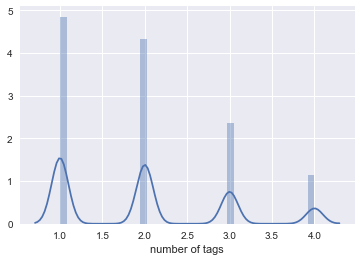

In [19]:
#tags.groupby('Id').count()
fig, ax = plt.subplots()
sns.distplot(tags.groupby('Id').count())
ax.set_xlabel('number of tags')

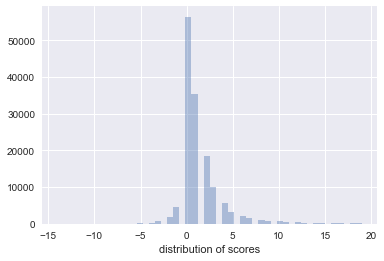

In [22]:
fig, ax = plt.subplots()
sns.distplot(questions[questions.Score< 20].Score,kde=False)
ax.set_xlabel('distribution of scores')

In [33]:
tagsByquestion = tags.groupby('Id',as_index=False).agg(lambda x: ' '.join(x))

In [34]:
tagsByquestion.head()

,Id,Tag
0,77434,vector
1,79709,memory function global-variables side-effects
2,95007,math statistics
3,103312,file file-io eof
4,255697,math statistics bayesian dirichlet


In [35]:
dfFinal = dfFinal.merge(tagsByquestion,on='Id',how='left')

In [36]:
dfFinal.head()

,Id,OwnerUserId,CreationDate,Score,Title,QuestionBody,CodeBody,Tag
0,77434,14008,2008-09-16T21:40:29Z,134,How to access the last value in a vector?,Suppose I have a vector that is nested in a d...,length() $# dat$vec1$vec2[$#] dat$vec1$ve...,vector
1,95007,15842,2008-09-18T17:59:19Z,48,Explain the quantile() function in R,I've been mystified by the R quantile functio...,NaN,math statistics
2,439526,37751,2009-01-13T15:58:48Z,21,Thinking in Vectors with R,I know that R works most efficiently with vec...,st p1 p2 st&lt;-NULL p1&lt;-NULL p2&lt;-NU...,vector
3,445059,37751,2009-01-14T23:09:02Z,12,Vectorize my thinking: Vector Operations in R,So earlier I answered my own question on thin...,for (j in my.data$item[my.data$fixed==0]) { #...,vector
4,476726,277,2009-01-24T21:56:23Z,8,Filtering data in R,I have a CSV of file of data that I can load ...,read.csv() NULL DocID Anno1 Anno7 ...,filtering


In [37]:
tagNum = tags.groupby('Id')['Tag'].count()
tagNum.columns = ['Id', 'tagNum']
tagNum = pd.DataFrame(tagNum).reset_index(level=0)

In [38]:
dfFinal = dfFinal.merge(tagNum, on='Id',how='left')

In [39]:
dfFinal.head()

,Id,OwnerUserId,CreationDate,Score,Title,QuestionBody,CodeBody,Tag_x,Tag_y
0,77434,14008,2008-09-16T21:40:29Z,134,How to access the last value in a vector?,Suppose I have a vector that is nested in a d...,length() $# dat$vec1$vec2[$#] dat$vec1$ve...,vector,1.0
1,95007,15842,2008-09-18T17:59:19Z,48,Explain the quantile() function in R,I've been mystified by the R quantile functio...,NaN,math statistics,2.0
2,439526,37751,2009-01-13T15:58:48Z,21,Thinking in Vectors with R,I know that R works most efficiently with vec...,st p1 p2 st&lt;-NULL p1&lt;-NULL p2&lt;-NU...,vector,1.0
3,445059,37751,2009-01-14T23:09:02Z,12,Vectorize my thinking: Vector Operations in R,So earlier I answered my own question on thin...,for (j in my.data$item[my.data$fixed==0]) { #...,vector,1.0
4,476726,277,2009-01-24T21:56:23Z,8,Filtering data in R,I have a CSV of file of data that I can load ...,read.csv() NULL DocID Anno1 Anno7 ...,filtering,1.0


In [40]:
dfFinal.columns

Index([          u'Id',  u'OwnerUserId', u'CreationDate',        u'Score',
              u'Title', u'QuestionBody',     u'CodeBody',        u'Tag_x',
              u'Tag_y'],
      dtype='object')

In [79]:
dfFinal.loc[dfFinal.Score<0,'label'] = 'Bad'
dfFinal.loc[dfFinal.Score>=5,'label'] = 'Good'

In [80]:
dfFinal.head()

,Id,OwnerUserId,CreationDate,Score,Title,QuestionBody,CodeBody,Tag_x,Tag_y,label
0,77434,14008,2008-09-16T21:40:29Z,134,How to access the last value in a vector?,Suppose I have a vector that is nested in a d...,length() $# dat$vec1$vec2[$#] dat$vec1$ve...,vector,1.0,Good
1,95007,15842,2008-09-18T17:59:19Z,48,Explain the quantile() function in R,I've been mystified by the R quantile functio...,NaN,math statistics,2.0,Good
2,439526,37751,2009-01-13T15:58:48Z,21,Thinking in Vectors with R,I know that R works most efficiently with vec...,st p1 p2 st&lt;-NULL p1&lt;-NULL p2&lt;-NU...,vector,1.0,Good
3,445059,37751,2009-01-14T23:09:02Z,12,Vectorize my thinking: Vector Operations in R,So earlier I answered my own question on thin...,for (j in my.data$item[my.data$fixed==0]) { #...,vector,1.0,Good
4,476726,277,2009-01-24T21:56:23Z,8,Filtering data in R,I have a CSV of file of data that I can load ...,read.csv() NULL DocID Anno1 Anno7 ...,filtering,1.0,Good


In [81]:
dfFinal.columns

Index([          u'Id',  u'OwnerUserId', u'CreationDate',        u'Score',
              u'Title', u'QuestionBody',     u'CodeBody',        u'Tag_x',
              u'Tag_y',        u'label'],
      dtype='object')

In [82]:
dftest = dfFinal.drop(['OwnerUserId','CreationDate','Score','CodeBody'],\
                      axis=1)

In [83]:
Y = dftest.label
X = dftest.drop(['label','Id'], axis=1)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.30)

In [84]:
'''This is our baseline of model accuracy. We need to beat this accuracy 
while trying to maximize our recall on bad labels.'''

def dummyGuess(x):
    return pd.Series(['Good'] * len(x))

In [85]:
accuracy_score(Y_test, dummyGuess(Y_test))

0.64366373902133001

In [101]:
'''Using nltk tokenizer will significantly slow down the fitting time but will slightly increase the accuracy.
I trained the model with default tokenizer and then switched to nltk tokenizer later on'''

pipeline = Pipeline([
    ('features', FeatureUnion(
        transformer_list = [
        ('title',Pipeline([
            ('count', TfidfVectorizer(stop_words=stopset,min_df=0.03,max_df=0.7,tokenizer=nltk.word_tokenize)),
        ])),
        ('question', Pipeline([
            ('tfidf', CountVectorizer(stop_words=stopset,min_df=0.01,max_df=0.8,tokenizer=nltk.word_tokenize)),
        ])),
    ],
    # the weight was trained seperately, 
    # I also controlled the weight to be fairly equal assignned.
    transformer_weights={
            'title':0.6,
            'question': 0.4
        }
            )),
    ('scaler',Normalizer()),    
    ('estimators', SGDClassifier(alpha=0.001,loss='modified_huber',penalty='l2')),
])

In [98]:
pipeline.fit(X_train, Y_train)
y = pipeline.predict(X_test)
accuracy_score(Y_test, y)
print(classification_report(Y_test, y))

ValueError: Found input variables with inconsistent numbers of samples: [4, 14877]

In [100]:
test = pipeline.predict_proba(X_test)
predict = ['Bad' if pair[0]>=0.35 else 'Good' for pair in test]

print(classification_report(Y_test,predict))

print(accuracy_score(Y_test,predict))

TypeError: object of type 'NoneType' has no len()